# Imports

In [71]:
# Standard Libraries
import os
import io
import math
import time
import random
import tempfile
import warnings
from multiprocessing import Manager
from typing import Optional

# Third-party Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import SimpleITK as sitk
import torch
import torch.nn as nn
import torchio as tio
from torch.utils.data import DataLoader, Dataset, random_split
from torch.cuda.amp import GradScaler, autocast

# MONAI Libraries
from monai.config import print_config
from monai.data import DataLoader
from monai.utils import set_determinism

# Custom Libraries
from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler, DDIMScheduler
from dataloader import Train ,Eval,Eval_sim

# Configuration
sitk.ProcessObject.SetGlobalDefaultThreader("Platform")
warnings.filterwarnings('ignore')


JUPYTER_ALLOW_INSECURE_WRITES=True

In [72]:
import statsmodels.stats.multitest as mt

In [73]:
import torch
import numpy as np
import random

def generate_3d_mask(mask_size, block_size, num_blocks):
    # Create a 3D mask with zeros
    mask = torch.zeros(mask_size, dtype=torch.uint8)

    # Iterate to add random blocks
    for _ in range(num_blocks):
        # Random start coordinates for the block
        x, y, z = [random.randint(0, mask_size[i] - block_size) for i in range(3)]
        
        # Place the 3x3x3 block
        mask[x:x+block_size, y:y+block_size, z:z+block_size] = 1

    return mask




In [74]:
import numpy as np
import torch

def generate_3d_mask_block(mask_size, block_size, fill_probability):
    # Calculate the number of blocks along each dimension
    num_blocks = np.array(mask_size) // block_size

    # Create an array of random numbers (0 or 1) based on fill_probability
    random_blocks = np.random.choice([0, 1], size=num_blocks, p=[1-fill_probability, fill_probability])

    # Expand the blocks to the desired size
    mask = np.kron(random_blocks, np.ones((block_size, block_size, block_size)))

    # If the mask_size is not exactly divisible by block_size, trim the excess
    mask = mask[:mask_size[0], :mask_size[1], :mask_size[2]]

    # Convert to a PyTorch tensor
    return torch.tensor(mask, dtype=torch.uint8)

# Set seeds and configs

In [75]:
# Initialize Configuration
config = {
    'batch_size': 1,
    'imgDimResize': (160, 192, 160),
    'imgDimPad': (208, 256, 208),
    'spatialDims': '3D',
    'unisotropic_sampling': True,
    'perc_low': 1,
    'perc_high': 99,
    'rescaleFactor': 2,
    'base_path': '',
}

# Seed and Device Configuration
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CUDA and CUDNN Configuration
# Uncomment the following line to specify CUDA_VISIBLE_DEVICES
# os.environ['CUDA_VISIBLE_DEVICES'] = '2,3,5,6'
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# SimpleITK Configuration
# Set the default number of threads and global behavior for SimpleITK
sitk.ProcessObject.SetGlobalDefaultThreader("Platform")



True

# Load the data

In [76]:
imgpath = {}
csvpath_trains=['./combined.csv']
pathBase = '/scratch1/akrami/Data_train'
csvpath_val = './Data/splits/IXI_val_fold0.csv'
csvpath_test = './Data/splits/simulated.csv'
csvpath_test_lesion = './Data/splits/Brats21_sub_test.csv'
var_csv = {}
states = ['train','val','test','test_lesion']

df_list = []

# Loop through each CSV file path and read it into a DataFrame
for csvpath in csvpath_trains:
    df = pd.read_csv(csvpath)
    df_list.append(df)

# %%
var_csv['train'] =pd.concat(df_list, ignore_index=True)
var_csv['val'] = pd.read_csv(csvpath_val)
var_csv['test'] = pd.read_csv(csvpath_test).tail(1)
var_csv['test_lesion'] = pd.read_csv(csvpath_test_lesion)
# if cfg.mode == 't2':
#     keep_t2 = pd.read_csv(cfg.path.IXI.keep_t2) # only keep t2 images that have a t1 counterpart

for state in states:
    var_csv[state]['settype'] = state
    var_csv[state]['norm_path'] =''
    if state !='test':
        var_csv[state]['img_path'] = pathBase  + var_csv[state]['img_path']
        var_csv[state]['mask_path'] = pathBase  + var_csv[state]['mask_path']
    if state !='test' and state !='test_lesion':
        var_csv[state]['seg_path'] =  var_csv[state]['mask_path']
    if state =='test_lesion':
        var_csv[state]['seg_path'] =  pathBase  + var_csv[state]['seg_path']

print(var_csv['test']['mask_path'])
data_train = Train(var_csv['train'],config) 
data_val = Train(var_csv['val'],config)                
data_test = Eval_sim(var_csv['test'],config)
data_test_lesion = Eval(var_csv['test_lesion'],config)



#data_train = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/IXI_train_fold0.csv', converters={'img_path': pd.eval}), config)
#train_loader = DataLoader(data_train, batch_size=config.get('batch_size', 1),shuffle=True,num_workers=8)

#data_val = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/IXI_val_fold0.csv', converters={'img_path': pd.eval}), config)
val_loader = DataLoader(data_val, batch_size=config.get('batch_size', 1),shuffle=True,num_workers=8)

#data_test = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/Brats21_test.csv', converters={'img_path': pd.eval}), config)
test_loader = DataLoader(data_test, batch_size=config.get('batch_size', 1),shuffle=False,num_workers=8)


device = torch.device("cuda")

1    /project/ajoshi_27/akrami/3D_lesion_DF/preproc...
Name: mask_path, dtype: object


In [77]:
test_lesion_loader = DataLoader(data_test_lesion, batch_size=config.get('batch_size', 1),shuffle=False,num_workers=8)

# Load the model

In [78]:
device = torch.device("cuda")

model = DiffusionModelUNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    num_channels=[32, 64, 128, 128],
    attention_levels=[False, False, False,True],
    num_head_channels=[0, 0, 0,32],
    num_res_blocks=2,
)
model.to(device)
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="scaled_linear_beta", beta_start=0.0005, beta_end=0.0195)

inferer = DiffusionInferer(scheduler)

optimizer = torch.optim.Adam(params=model.parameters(), lr=5e-5)

Using 2 GPUs!


In [79]:
# specify your model filename
#model_filename = '/scratch1/akrami/models/3Ddiffusion/half/model_epoch984.pt'
model_filename ='/project/ajoshi_27/akrami/3D_lesion_DF/models/half/model_epoch549.pt'
# load state_dict into the model
model.load_state_dict(torch.load(model_filename))

# if you need to set the model in evaluation mode
model.eval()

DataParallel(
  (module): DiffusionModelUNet(
    (conv_in): Convolution(
      (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (time_embed): Sequential(
      (0): Linear(in_features=32, out_features=128, bias=True)
      (1): SiLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (down_blocks): ModuleList(
      (0): DownBlock(
        (resnets): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 32, eps=1e-06, affine=True)
            (nonlinearity): SiLU()
            (conv1): Convolution(
              (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            )
            (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
            (norm2): GroupNorm(32, 32, eps=1e-06, affine=True)
            (conv2): Convolution(
              (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            )
       

# Generate an Image

In [80]:
sub_test = next(iter(test_lesion_loader))
print(sub_test.keys())
print(sub_test['age'])

dict_keys(['vol', 'peak', 'seg', 'age', 'ID', 'path', 'mask'])
tensor([nan], dtype=torch.float64)


In [81]:

# Expand the dimensions of sub_test['peak'] to make it [1, 1, 1, 1, 4]
peak_expanded = (sub_test['peak'].unsqueeze(1).unsqueeze(2).unsqueeze(3).unsqueeze(4)).long()
# Move both tensors to the device
image_array = sub_test['vol']['data'].to(device)
seg = sub_test['seg']['data'].to(device)
peak_expanded = peak_expanded.to(device)
image_array = (image_array / peak_expanded)
middle_slice_idx = image_array.size(-1) // 2

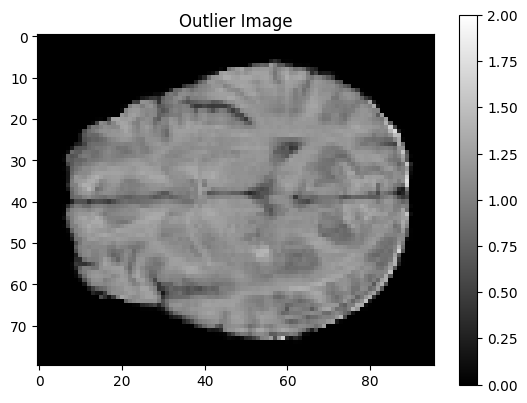

In [82]:
plt.imshow(image_array[0,0][:,:,middle_slice_idx].squeeze().cpu().numpy(), cmap='gray', vmin=0, vmax=2)
plt.title('Outlier Image')
plt.colorbar()
plt.show()

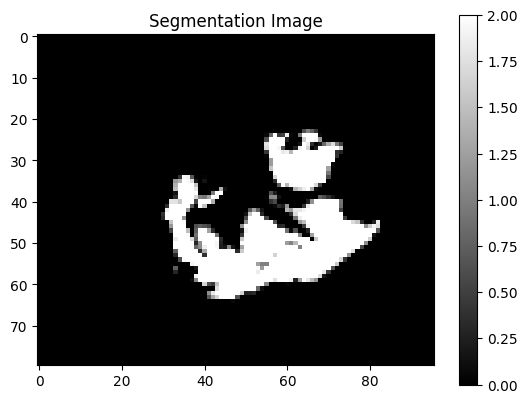

In [83]:
plt.imshow(seg[0,0][:,:,middle_slice_idx].squeeze().cpu().numpy(), cmap='gray', vmin=0, vmax=2)
plt.title('Segmentation Image')
plt.colorbar()
plt.show()

In [84]:
# Define the size of your 3D mask, block size, and number of blocks
x_d,y_d,z_d = image_array[0,0].shape
mask_size = (x_d, y_d, z_d)  # Change as needed
block_size =10 # Size of the block in each dimension
num_blocks = 400 # Number of blocks

# Generate the mask
mask = generate_3d_mask(mask_size, block_size, num_blocks)



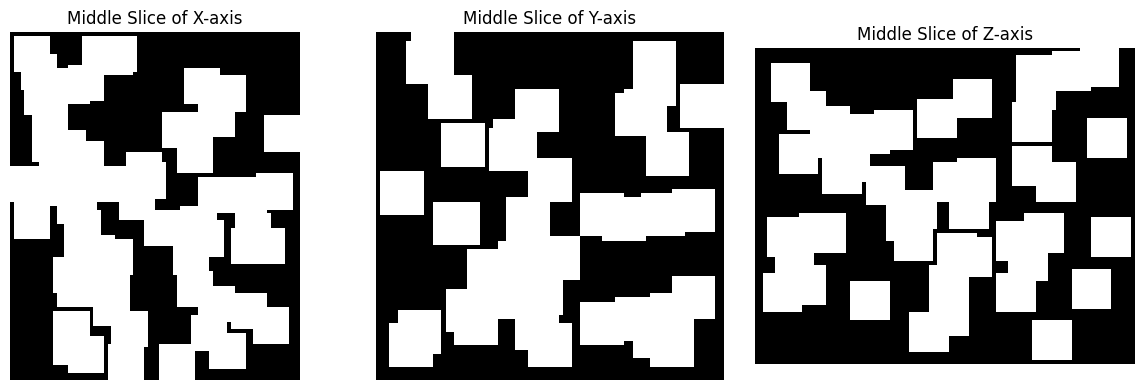

In [85]:
import matplotlib.pyplot as plt

def plot_slices(mask):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Plot the middle slice of each axis
    axes[0].imshow(mask[mask.shape[0] // 2, :, :], cmap='gray')
    axes[0].set_title('Middle Slice of X-axis')
    axes[0].axis('off')

    axes[1].imshow(mask[:, mask.shape[1] // 2, :], cmap='gray')
    axes[1].set_title('Middle Slice of Y-axis')
    axes[1].axis('off')

    axes[2].imshow(mask[:, :, mask.shape[2] // 2], cmap='gray')
    axes[2].set_title('Middle Slice of Z-axis')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# Assuming 'mask' is your 3D tensor generated from the previous step
plot_slices(mask)


In [87]:
fill_probability = 0.5  # Probability of a block being filled
# Define the size of your 3D mask, block size, and number of blocks
x_d,y_d,z_d = image_array[0,0].shape
mask_size = (x_d, y_d, z_d)  # Change as needed
block_size =10 # Size of the block in each dimension
num_blocks = 400 # Number of blocks
# Generate the mask
mask = generate_3d_mask_block(mask_size, block_size, num_blocks)


ValueError: probabilities are not non-negative

In [ ]:
import matplotlib.pyplot as plt

def plot_slices(mask):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Plot the middle slice of each axis
    axes[0].imshow(mask[mask.shape[0] // 2, :, :], cmap='gray')
    axes[0].set_title('Middle Slice of X-axis')
    axes[0].axis('off')

    axes[1].imshow(mask[:, mask.shape[1] // 2, :], cmap='gray')
    axes[1].set_title('Middle Slice of Y-axis')
    axes[1].axis('off')

    axes[2].imshow(mask[:, :, mask.shape[2] // 2], cmap='gray')
    axes[2].set_title('Middle Slice of Z-axis')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# Assuming 'mask' is your 3D tensor generated from the previous step
plot_slices(mask)


In [65]:
import torch
import numpy as np
from scipy.ndimage import binary_dilation, binary_erosion
from scipy.ndimage.morphology import generate_binary_structure

def morphological_processing(mask, kernel_size):
    # Convert the mask to NumPy array
    mask_np = mask.numpy().astype(np.bool)

    # Create a structuring element (kernel)
    kernel = generate_binary_structure(3, 1)
    kernel = binary_dilation(kernel, iterations=(kernel_size // 2))

    # Apply dilation followed by erosion
    dilated_mask = binary_dilation(mask_np, structure=kernel)
    processed_mask = binary_erosion(dilated_mask, structure=kernel)

    # Convert back to PyTorch tensor
    return torch.from_numpy(processed_mask.astype(np.uint8))

# Assuming 'mask' is your 3D tensor mask
kernel_size = 64  # Size of the structuring element
processed_mask = morphological_processing(mask, kernel_size)

# Optionally, you can visualize the processed mask to see the effect
# plot_slices(processed_mask)  # Assuming you have the plot_slices function from earlier


# Optionally, you can visualize the processed mask to see the effect
# plot_slices(processed_mask)  # Assuming you have the plot_slices function from earlier


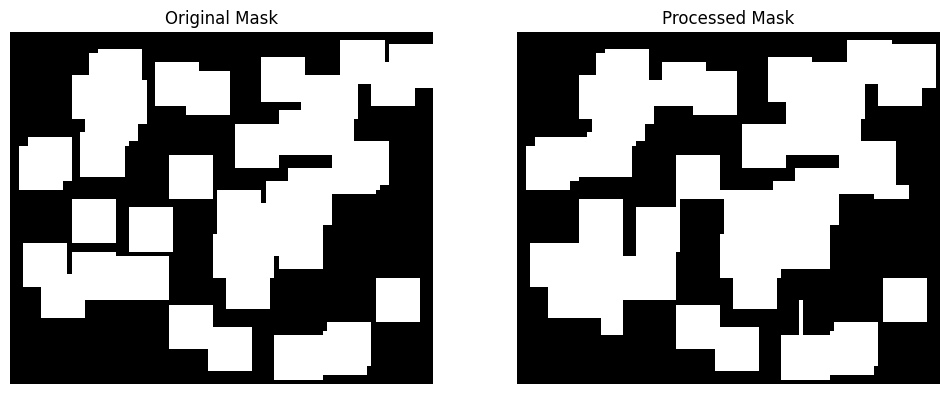

In [66]:
import matplotlib.pyplot as plt

def plot_middle_slice(mask, title):
    # Select the middle slice along the z-axis
    middle_slice = mask[:, :, mask.shape[2] // 2]

    # Plot the middle slice
    plt.imshow(middle_slice, cmap='gray')
    plt.title(title)
    plt.axis('off')  # Turn off axis labels

# Assuming 'mask' is your original 3D tensor mask and 'processed_mask' is the mask after morphological processing
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_middle_slice(mask, 'Original Mask')

plt.subplot(1, 2, 2)
plot_middle_slice(processed_mask, 'Processed Mask')

plt.show()


In [67]:
image_array[image_array<0.01]=0
mask = 1-mask
filtred_img = image_array*(processed_mask).to(device)

In [68]:
print(mask.shape)

torch.Size([80, 96, 80])


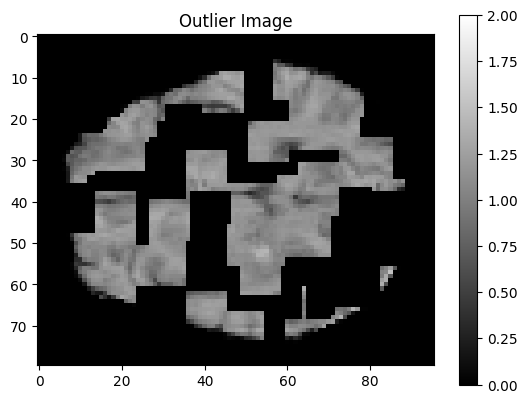

In [69]:
plt.imshow(filtred_img[0,0][:,:,middle_slice_idx].squeeze().cpu().numpy(), cmap='gray', vmin=0, vmax=2)
plt.title('Outlier Image')
plt.colorbar()
plt.show()

# Denoise test samples

In [27]:
def denoise(noised_img,sample_time,scheduler,inferer,model):
    with torch.no_grad():
        with autocast(enabled=True):
            for t in range(sample_time - 1, -1, -1):
                batch_size = noised_img.size(0)  # Get the batch size
                t_batch=torch.Tensor((t,)).to(noised_img.device)
                t_batch = t_batch.unsqueeze(0).expand(batch_size, -1)  # Expand tensor `t` to have the desired batch size
                t_batch = t_batch.to(noised_img.device)[:,0] 
                model_output = model(noised_img, timesteps=t_batch)
                noised_img, _ = scheduler.step(model_output, t, noised_img)
            return noised_img

    

In [28]:
def denoise_epistemic(noised_img,sample_time,scheduler,inferer,model):
    max_sample_time= sample_time[-1]
    current_time = sample_time[-2]
    i=-2
    noised_img_org = noised_img.clone()
    with torch.no_grad():
        with autocast(enabled=True):
            for t in range(max_sample_time - 1, -1, -1):
                batch_size = noised_img.size(0)  # Get the batch size
                t_batch=torch.Tensor((t,)).to(noised_img.device)
                t_batch = t_batch.unsqueeze(0).expand(batch_size, -1)  # Expand tensor `t` to have the desired batch size
                t_batch = t_batch.to(noised_img.device)[:,0] 
                model_output = model(noised_img, timesteps=t_batch)
                noised_img, _ = scheduler.step(model_output, t, noised_img)
                if t == current_time:
                    noised_img [i,:,:,:,:]= noised_img_org[i,:,:,:,:]
                    i-=1
                    if i != -6: #TODO hard coded
                        current_time = sample_time[i]
            return noised_img

    

In [29]:
# n = 5  # For example, if you want to repeat it 5 times

# # Repeat the tensor
# repeated_image_array = image_array.repeat(n, 1, 1, 1, 1) 

In [ ]:
mask_1 = mask-1

In [43]:
model.eval()
import torch

# Convert the NumPy array to a PyTorch tensor
mask_tensor = torch.tensor(mask).float()

# Now move the tensor to the desired device
mask= mask_tensor.to(device)
import tqdm as tqdm
mask = mask.to(device)
val_image_masked = image_tensor.to(device)*mask
val_image_inpainted = torch.randn_like(val_image_masked).to(device)
timesteps = torch.Tensor((999,)).to(mask.device).long()
scheduler.set_timesteps(num_inference_steps=999)
progress_bar = tqdm.tqdm(scheduler.timesteps)

num_resample_steps = 4
with torch.no_grad():
    with autocast(enabled=True):
        for t in progress_bar:
            for u in range(num_resample_steps):
                # get the known portion at t-1
                if t > 0:
                    noise =  torch.randn_like(val_image_masked).to(device)
                    timesteps_prev = torch.Tensor((t - 1,)).to(device).long()
                    val_image_inpainted_prev_known = scheduler.add_noise(
                        original_samples=val_image_masked, noise=noise, timesteps=timesteps_prev
                    )
                else:
                    val_image_inpainted_prev_known = val_image_masked
                
                # perform a denoising step to get the unknown portion at t-1
                if t > 0:
                    timesteps = torch.Tensor((t,)).to(device).long()
                    model_output = model(val_image_inpainted, timesteps=timesteps)
                    val_image_inpainted_prev_unknown, _ = scheduler.step(model_output, t, val_image_inpainted)

                # combine known and unknown using the mask
                val_image_inpainted = torch.where(
                    mask == 1, val_image_inpainted_prev_known, val_image_inpainted_prev_unknown
                )

                # perform resampling
                if t > 0 and u < (num_resample_steps - 1):
                    # sample x_t from x_t-1
                    noise = torch.randn_like(val_image_masked).to(device)
                    val_image_inpainted = (
                        torch.sqrt(1 - scheduler.betas[t - 1]) * val_image_inpainted
                        + torch.sqrt(scheduler.betas[t - 1]) * noise
                    )



torch.Size([1, 1, 80, 96, 80])


50it [01:53,  2.27s/it]


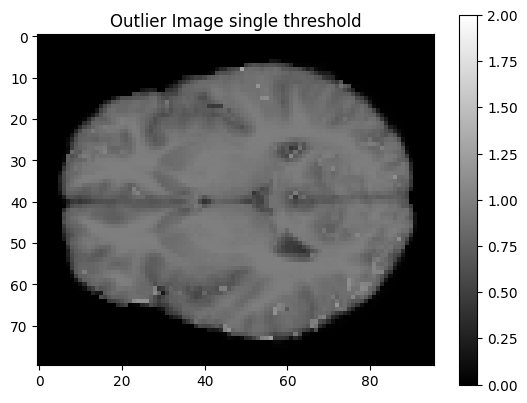

In [44]:

plt.imshow(val_image_masked[0,0][:,:,middle_slice_idx].squeeze().cpu().numpy(), cmap='gray', vmin=0, vmax=2)
plt.title('Outlier Image single threshold')
plt.colorbar()
plt.show()

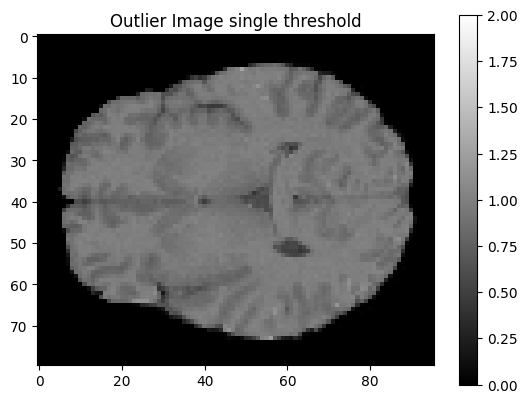

In [45]:

plt.imshow(val_image_inpainted[0,0][:,:,middle_slice_idx].squeeze().cpu().numpy(), cmap='gray', vmin=0, vmax=2)
plt.title('Outlier Image single threshold')
plt.colorbar()
plt.show()

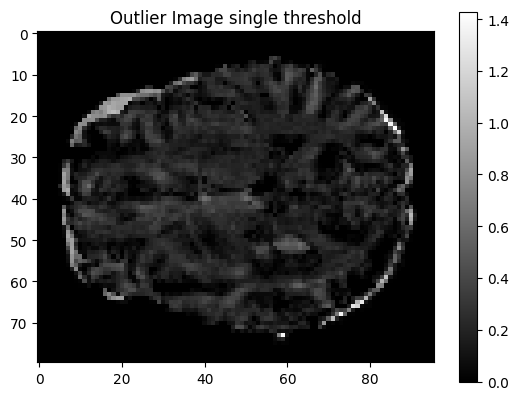

In [48]:
plt.imshow(torch.abs(val_image_inpainted[0,0][:,:,middle_slice_idx]-repeated_image_array[0,0][:,:,middle_slice_idx]).squeeze().cpu().numpy(), cmap='gray')
plt.title('Outlier Image single threshold')
plt.colorbar()
plt.show()